In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
folder = "/Users/lilli/Desktop/ESPM"

In [3]:
from __future__ import annotations
import numpy as np

from mflex.simulate.simulate_boundary import dalmatian

from mhsflex.field2d import Field2dData, check_fluxbalance, alpha_HS04
from mhsflex.field3d import Field3dData, calculate_magfield, j3d, lf3d
from mhsflex.vis import plot, plot_plasma_parameters, show_poles, show_footpoints
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt
from scipy.io import readsav


rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)
norm = colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
nresol_x = 200
nresol_y = 200
nresol_z = 400
xmin = 0.0
xmax = 20.0  # Mm
ymin = 0.0
ymax = 20.0
zmin = 0.0
zmax = 20.0
pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z

z0 = 2
deltaz = 0.2

z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
B_PHOTO = 500
data_bz = np.zeros((nresol_y, nresol_x))

for ix in range(0, nresol_x):
    for iy in range(0, nresol_y):
        x = x_arr[ix] / 10.0
        y = y_arr[iy] / 10.0
        data_bz[iy, ix] = dalmatian(x, y) * B_PHOTO

data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nresol_x,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

In [5]:
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

In [6]:
cmap4 = colors.LinearSegmentedColormap.from_list(
    "cmap3",
    (
        (0.000, c4),
        (1.000, (1.000, 0.514, 0.890)),
    ),
)

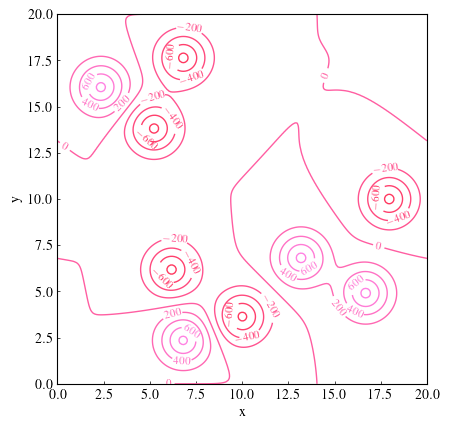

In [88]:
fig = plt.figure()
ax = fig.add_subplot(111)

CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((- 750, -600, -400, -200, 0, 200, 400, 600, 750)),
    cmap=cmap4,
    linewidths=1.0,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=8, inline=True)
#ax.clabel(CS2, fontsize=14, inline=True)
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plotname =  folder + "/contourcombi.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

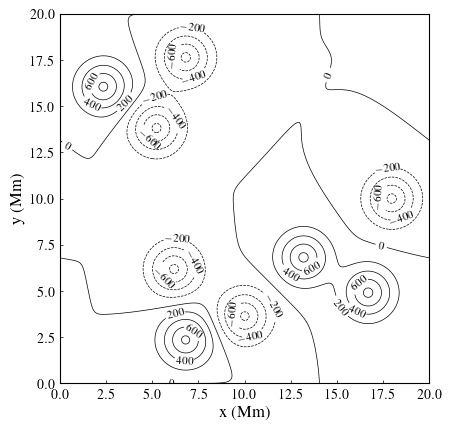

In [234]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels = np.array((- 750, -600, -400, -200, 0, 200, 400, 600, 750)),
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x (Mm)", fontsize=12)
ax.set_ylabel("y (Mm)", fontsize=12)
ax.clabel(CS, fontsize=8, inline=True)
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/contour.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [7]:
alpha = 0.04
length_scale = float(2.0)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * pixelsize_x
length_scale_y = 2.0 * nresol_y * pixelsize_y

length_scale_x_norm = length_scale_x / length_scale 
length_scale_y_norm = length_scale_y / length_scale 

kx_arr = np.arange(200) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(200) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(200) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[1, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[0, 1] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2

# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = 1 / 2 * (1 - alpha**2 / k2_arr)

print(limit.min())

0.48378861061722594


In [8]:
b = 1.0
alff = 0.0
amhs1 = 0.24
amhs2 = 0.48
z0 = 2.0
deltaz = 0.2

In [9]:
#data3dp = calculate_magfield(data2d, 0.0, b, 0.0, z0, deltaz)
data3dl = calculate_magfield(data2d, 0.0, b, alpha, z0, deltaz)
data3dmhs1 = calculate_magfield(data2d, amhs1, b, alpha, z0, deltaz)
data3dmhs2 = calculate_magfield(data2d, amhs2, b, alpha, z0, deltaz)

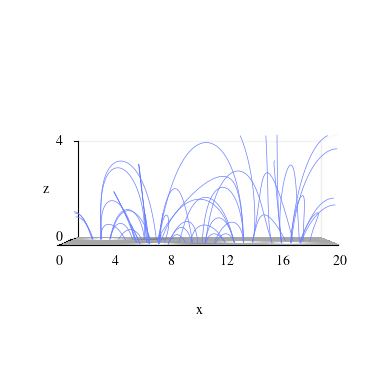

In [170]:
# plot(data3dp, "angular", False, True, path=folder, zoom=True)
plot(data3dl, "side", False, True, path=folder, zoom=True)
# plot(data3dmhs1, "angular", False, True, path=folder, zoom=True)
# plot(data3dmhs2, "angular", False, True, path=folder, zoom=True)

In [10]:
T_PHOTOSPHERE = 5600.0  # Photospheric temperature
T_CORONA = 2.0 * 10.0**6  # Coronal temperature

G_SOLAR = 272.2  # m/s^2
KB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
MBAR = 1.67262 * 10**-27  # mean molecular weight (proton mass)
RHO0 = 2.7 * 10**-4  # plasma density at z = 0 in kg/(m^3)
P0 = T_PHOTOSPHERE * KB * RHO0 / MBAR  # plasma pressure in kg/(s^2 m)
MU0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)

L = 10**6  # Lengthscale Mm
T0 = (T_PHOTOSPHERE + T_CORONA * np.tanh(data3dmhs1.z0 / data3dmhs1.deltaz)) / (
    1.0 + np.tanh(data3dmhs1.z0 / data3dmhs1.deltaz)
)
H = KB * T0 / (MBAR * G_SOLAR) / L
B0 = data3dmhs1.field[
    :, :, 0, 2
].max()  # Gauss background magnetic field strength in 10^-4 kg/(s^2A) = 10^-4 T
PB0 = (B0 * 10**-4) ** 2 / (
    2 * MU0
)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2m)
BETA0 = P0 / PB0  # Plasma Beta, ration plasma to magnetic pressure

In [11]:
dpmhs1_max = np.zeros_like(z_arr)
dpmhs1_min = np.zeros_like(z_arr)

dpmhs2_max = np.zeros_like(z_arr)
dpmhs2_min = np.zeros_like(z_arr)

for iz in range(nresol_z):
    dpmhs1_max[iz] = data3dmhs1.dpressure[:, :, iz].max()
    dpmhs1_min[iz] = data3dmhs1.dpressure[:, :, iz].min()
    dpmhs2_max[iz] = data3dmhs2.dpressure[:, :, iz].max()
    dpmhs2_min[iz] = data3dmhs2.dpressure[:, :, iz].min()


In [20]:
cmap4 = colors.LinearSegmentedColormap.from_list(
    "cmap3",
    (
        (0.000, c4),
        (1.000, (1.000, 0.514, 0.890)),
    ),
)

c4b = (1.000, 0.514, 0.890)

limehouse = (0.667, 1.000, 0.243)

dgreen = (0.000, 0.753, 0.137)

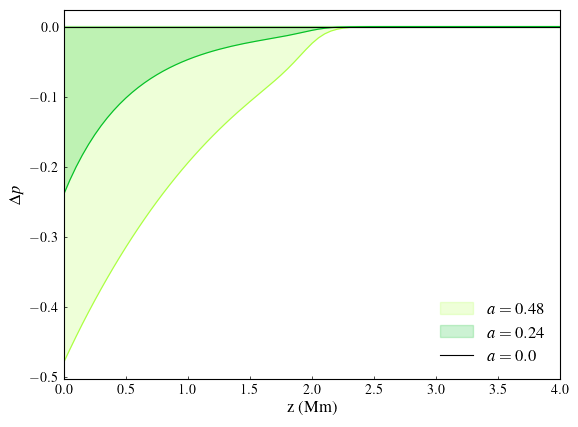

In [24]:
fig, ax1 = plt.subplots()
ax1.fill_between(data2d.z, dpmhs2_min, dpmhs2_max, color= limehouse, alpha=0.2, label=r"$a = 0.48$")
ax1.fill_between(data2d.z, dpmhs1_min, dpmhs1_max, color= dgreen, alpha=0.2, label=r"$a = 0.24$")
ax1.plot(
    data2d.z,
    dpmhs2_max,
    linewidth=0.8,
    color= limehouse,
    # label=r"B-den, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    dpmhs2_min,
    linewidth=0.8,
    color= limehouse,
    # label=r"B-den, $p_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    dpmhs1_max,
    linewidth=0.8,
    color= dgreen,
    # label=r"B-den, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    dpmhs1_min,
    linewidth=0.8,
    color= dgreen,
    # label=r"B-den, $p_0$ prescribed, linear",
)

ax1.plot(
    data2d.z,
    np.zeros_like(data2d.z),
    linewidth=0.8,
    color="black",
    label=r"$a = 0.0$",
)


ax1.set_ylabel(r"$\Delta p$", fontsize=12)
ax1.set_xlabel(r"z (Mm)", fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.tick_params(direction="in", length=2, width=0.5)
ax1.set_xlim(0, 4.0)
plotname = folder + "/dpres.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [16]:
ddmhs1_max = np.zeros_like(z_arr)
ddmhs1_min = np.zeros_like(z_arr)

ddmhs2_max = np.zeros_like(z_arr)
ddmhs2_min = np.zeros_like(z_arr)

for iz in range(nresol_z):
    ddmhs1_max[iz] = data3dmhs1.ddensity[:, :, iz].max()
    ddmhs1_min[iz] = data3dmhs1.ddensity[:, :, iz].min()
    ddmhs2_max[iz] = data3dmhs2.ddensity[:, :, iz].max()
    ddmhs2_min[iz] = data3dmhs2.ddensity[:, :, iz].min()

In [18]:
c10=(1.000, 0.416, 0.937)
c10b =(1.000, 0.000, 0.635)

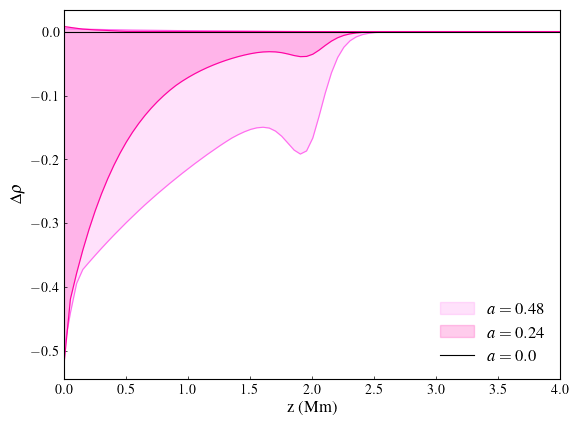

In [23]:
fig, ax1 = plt.subplots()
ax1.fill_between(data2d.z, ddmhs2_min, ddmhs2_max, color=c10, alpha=0.2, label=r"$a = 0.48$")
ax1.fill_between(data2d.z, ddmhs1_min, ddmhs1_max, color=c10b, alpha=0.2, label=r"$a = 0.24$")
ax1.plot(
    data2d.z,
    ddmhs2_max,
    linewidth=0.8,
    color=c10,
    # label=r"B-den, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    ddmhs2_min,
    linewidth=0.8,
    color=c10,
    # label=r"B-den, $p_0$ prescribed, linear",
)

ax1.plot(
    data2d.z,
    ddmhs1_max,
    linewidth=0.8,
    color=c10b,
    # label=r"B-den, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    ddmhs1_min,
    linewidth=0.8,
    color=c10b,
    # label=r"B-den, $p_0$ prescribed, linear",
)

ax1.plot(
    data2d.z,
    np.zeros_like(data2d.z),
    linewidth=0.8,
    color="black",
    label=r"$a = 0.0$",
)


ax1.set_ylabel(r"$\Delta \rho$", fontsize=12)
ax1.set_xlabel(r"z (Mm)", fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.tick_params(direction="in", length=2, width=0.5)
ax1.set_xlim(0, 4.0)
plotname = folder + "/dden.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [98]:
lfl = lf3d(data3dl)
lfmhs1 = lf3d(data3dmhs1)
lfmhs2 = lf3d(data3dmhs2)

In [99]:
jl = j3d(data3dl)
jmhs1 = j3d(data3dmhs1)
jmhs2 = j3d(data3dmhs2)

In [194]:
cmap3 = colors.LinearSegmentedColormap.from_list(
    "cmap3",
    (
        (0.000, (0.000, 0.365, 0.580)),
        (0.500, "white"),
        (1.000, (1.000, 0.537, 0.000)),
    ),
)

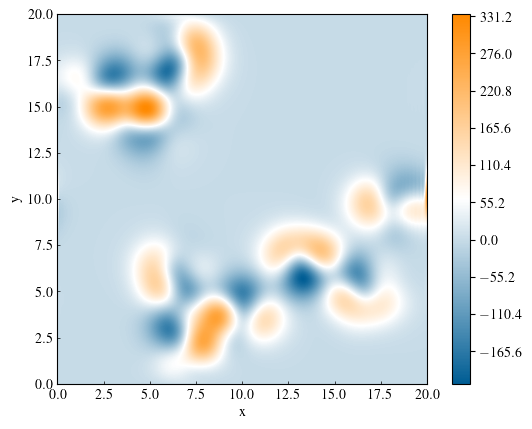

In [167]:
fig = plt.figure()
ax = fig.add_subplot(111)
C = ax.contourf(
    x_grid,
    y_grid,
    lfmhs2[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 0, 2],
    1000,
    cmap=cmap3, 
    vmin = lfmhs2[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 0, 2].min(), 
    vmax = lfmhs2[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 0, 2].max(),
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
fig.colorbar(C)
plotname = folder + "/lf_mhs2_0.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

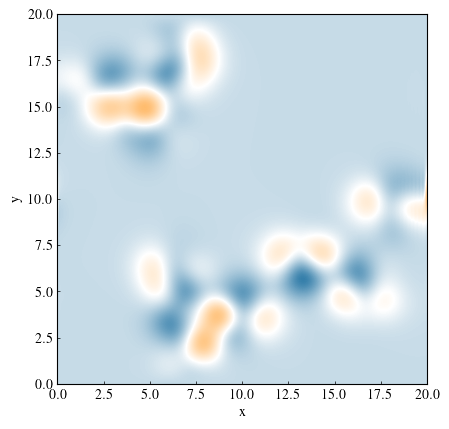

In [158]:
fig = plt.figure()
ax = fig.add_subplot(111)
C = ax.contourf(
    x_grid,
    y_grid,
    lfmhs1[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 0, 2],
    1000,
    cmap=cmap3, 
    vmin = lfmhs2[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 0, 2].min(), 
    vmax = lfmhs2[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 0, 2].max(),
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/lf_mhs1_0.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

Locator attempting to generate 1001 ticks ([-9.999999999999999e-14, ..., 1e-13]), which exceeds Locator.MAXTICKS (1000).


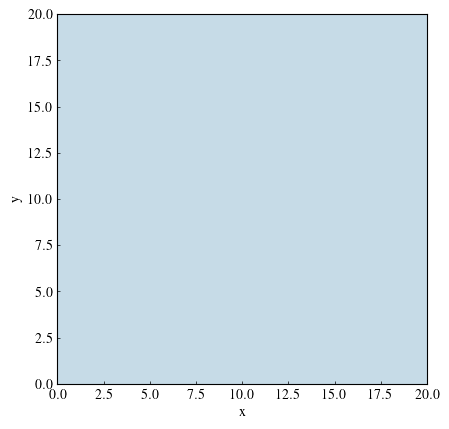

In [159]:
fig = plt.figure()
ax = fig.add_subplot(111)
C = ax.contourf(
    x_grid,
    y_grid,
    lfl[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 0, 2],
    1000,
    cmap=cmap3, 
    vmin = lfmhs2[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 0, 2].min(), 
    vmax = lfmhs2[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 0, 2].max(),
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
#fig.colorbar(C)
plotname = folder + "/lf_lff_0.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

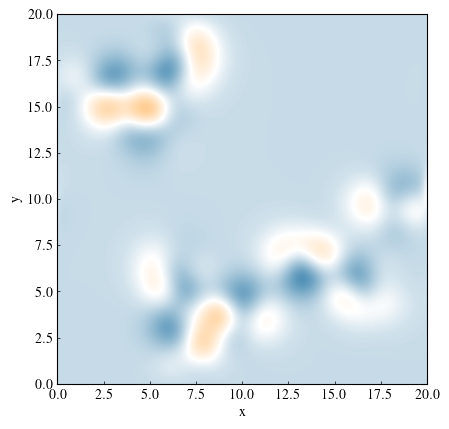

In [160]:
fig = plt.figure()
ax = fig.add_subplot(111)
C = ax.contourf(
    x_grid,
    y_grid,
    lfmhs2[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 20, 2],
    1000,
    cmap=cmap3, 
    vmin = lfmhs2[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 0, 2].min(), 
    vmax = lfmhs2[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 0, 2].max(),
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
#fig.colorbar(C)
plotname = folder + "/lf_mhs2_20.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

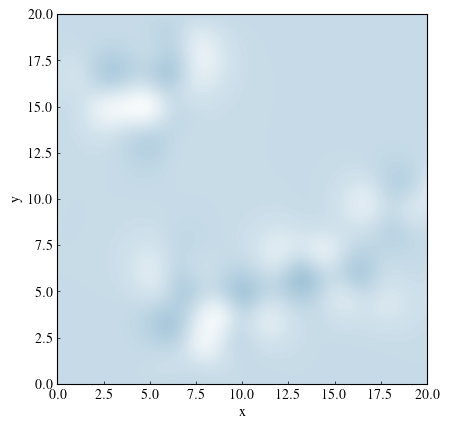

In [161]:
fig = plt.figure()
ax = fig.add_subplot(111)
C = ax.contourf(
    x_grid,
    y_grid,
    lfmhs1[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 20, 2],
    1000,
    cmap=cmap3, 
    vmin = lfmhs2[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 0, 2].min(), 
    vmax = lfmhs2[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 0, 2].max(),
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
#fig.colorbar(C)
plotname = folder + "/lf_mhs1_20.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

Locator attempting to generate 1001 ticks ([-21.75, ..., 28.25]), which exceeds Locator.MAXTICKS (1000).


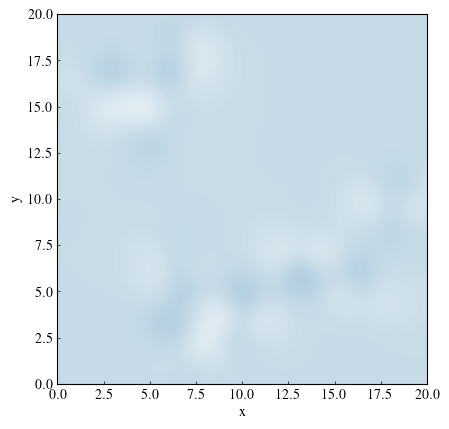

In [163]:
fig = plt.figure()
ax = fig.add_subplot(111)
C = ax.contourf(
    x_grid,
    y_grid,
    lfmhs2[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 40, 2],
    1000,
    cmap=cmap3, 
    vmin = lfmhs2[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 0, 2].min(), 
    vmax = lfmhs2[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 0, 2].max(),
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
#fig.colorbar(C)
plotname = folder + "/lf_mhs2_40.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

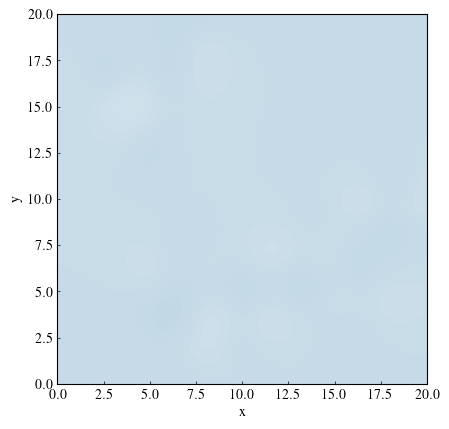

In [162]:
fig = plt.figure()
ax = fig.add_subplot(111)
C = ax.contourf(
    x_grid,
    y_grid,
    lfmhs1[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 40, 2],
    1000,
    cmap=cmap3, 
    vmin = lfmhs2[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 0, 2].min(), 
    vmax = lfmhs2[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 0, 2].max(),
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
#fig.colorbar(C)
plotname = folder + "/lf_mhs1_40.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

## ISSI RMHD CUT OUT

In [5]:
path = "/Users/lilli/Desktop/mflex/data/RMHD_boundary_data.sav"

data = readsav(path, python_dict=True, verbose=True)

--------------------------------------------------
Date: Tue Sep  6 15:18:26 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 10 records of which:
 - 1 are of type VERSION
 - 1 are of type NOTICE
 - 6 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - b2dx [<class 'numpy.ndarray'>]
 - b2dy [<class 'numpy.ndarray'>]
 - b2dz [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------


In [33]:
0.064 * 156

9.984

In [34]:
data_bz = data["b2dz"][130:218, 312:442]
data_bx = data["b2dx"][130:218, 312:442]
data_by = data["b2dy"][130:218, 312:442]

nresol_x = data_bz.shape[1]
nresol_y = data_bz.shape[0]

pixelsize_z_Mm = 64.0 * 10**-3  # Convert pixelsize from km into Mm
pixelsize_x_Mm = 192.0 * 10**-3
pixelsize_y_Mm = 192.0 * 10**-3

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

xmax_Mm = nresol_x * pixelsize_x_Mm
ymax_Mm = nresol_y * pixelsize_y_Mm
zmax_Mm = 20.8

nresol_z = int(np.floor(zmax_Mm / pixelsize_z_Mm))

z0 = 2000.0 * 10**-3

deltaz = z0 / 10

nf_max = min(nresol_x, nresol_y)

print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x", pixelsize_x_Mm)
print("pixelsize_y", pixelsize_y_Mm)
print("pixelsize_z", pixelsize_z_Mm)

xmax_Mm, ymax_Mm, zmax_Mm 24.96 16.896 20.8
nresol_x, nresol_y, nresol_z 130 88 325
pixelsize_x 0.192
pixelsize_y 0.192
pixelsize_z 0.064


In [35]:
data_bz.min()
x_arr = np.arange(nresol_x) * (xmax_Mm - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax_Mm - ymin) / (nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax_Mm - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

In [36]:
data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nf_max,
    pixelsize_x_Mm,
    pixelsize_y_Mm,
    pixelsize_z_Mm,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

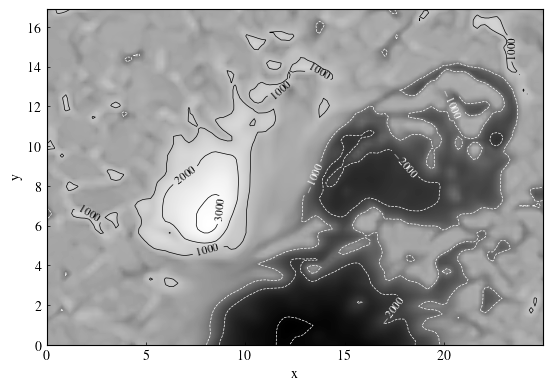

In [52]:
norm = colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.contourf(
    x_grid,
    y_grid,
    data2d.bz,
    1000,
    cmap=cmap, 
    #norm=norm,
)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((-3000, -2000, -1000)),
    colors="white",
    linewidths=0.5,
)
CS2 = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((1000, 2000, 3000)),
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=8, inline=True)
ax.clabel(CS2, fontsize=8, inline=True)
ax.set_box_aspect(ymax_Mm / xmax_Mm)
ax.tick_params(direction="in", length=2, width=0.5)
#plotname =  folder + "/contourcombi.png"
#plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [45]:
alpha_HS04(data_bx, data_by, data_bz)

0.03680842

In [53]:
alpha = alpha_HS04(data_bx, data_by, data_bz)

length_scale = float(2.0)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * pixelsize_x_Mm
length_scale_y = 2.0 * nresol_y * pixelsize_y_Mm

length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

kx_arr = np.arange(nf_max) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(nf_max) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(nf_max) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2


# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - (2 * alpha) ** 2) / (2 * k2_arr)

print(limit.min())
a = limit.min()

0.3289536688678313


In [54]:
data3d = calculate_magfield(data2d, a, 1.0, alpha, z0, deltaz)


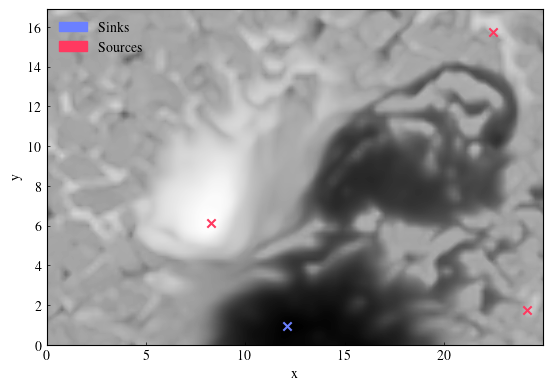

In [40]:
show_poles(data3d)

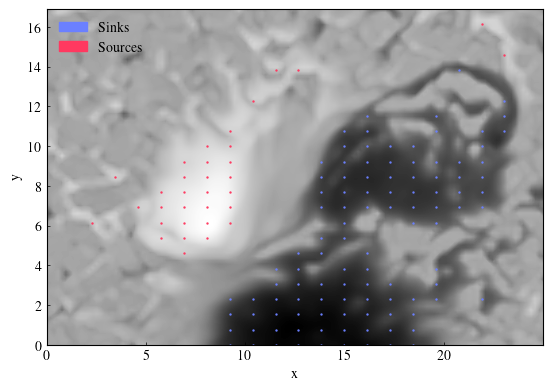

In [41]:
show_footpoints(data3d)

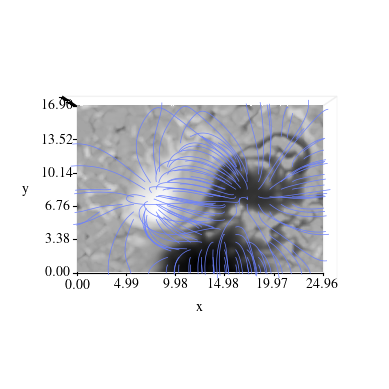

In [55]:
plot(data3d, 'los')

In [74]:
import scipy 

path3dref = "/Users/lilli/Desktop/mflex/data/RMHD_3D_data.sav"
data3dref = scipy.io.readsav(path3dref, python_dict=True, verbose=True)

pres_3d = data3dref["p3d"] * 10**-1
den_3d = data3dref["d3d"] * 10**3

T_PHOTOSPHERE = 6000.0  # Photospheric temperature
T_CORONA = 1500000.0  # Coronal temperature

G_SOLAR = 272.2  # m/s^2
KB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
MBAR = 1.67262 * 10**-27  # mean molecular weight (proton mass)

RHO0 = 2.7 * 10**-4  # plasma density at z = 0 in kg/(m^3)
P0 = T_PHOTOSPHERE * KB * RHO0/ MBAR  # plasma pressure in kg/(s^2 m)

MU0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)

P0 = pres_3d[0, :, :].max()
RHO0 = P0 * MBAR / (T_PHOTOSPHERE * KB)

L = 10**6  # Lengthscale Mm
T0 = 10000.0
H = KB * T0 / (MBAR * G_SOLAR) / L
B0 = data3d.field[
    :, :, 0, 2
].max()  # Gauss background magnetic field strength in 10^-4 kg/(s^2A) = 10^-4 T
PB0 = (B0 * 10**-4) ** 2 / (2 * MU0)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2m)

BETA0 = P0 / PB0  # Plasma Beta, ration plasma to magnetic pressure


--------------------------------------------------
Date: Tue Sep  6 15:19:40 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 12 records of which:
 - 1 are of type VERSION
 - 1 are of type NOTICE
 - 8 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - b3dx [<class 'numpy.ndarray'>]
 - b3dy [<class 'numpy.ndarray'>]
 - b3dz [<class 'numpy.ndarray'>]
 - d3d [<class 'numpy.ndarray'>]
 - p3d [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------


In [58]:
dpmhs_max = np.zeros_like(z_arr)
dpmhs_min = np.zeros_like(z_arr)
ddmhs_max = np.zeros_like(z_arr)
ddmhs_min = np.zeros_like(z_arr)

for iz in range(nresol_z):
    dpmhs_max[iz] = data3d.dpressure[:, :, iz].max()
    dpmhs_min[iz] = data3d.dpressure[:, :, iz].min()
    ddmhs_max[iz] = data3d.ddensity[:, :, iz].max()
    ddmhs_min[iz] = data3d.ddensity[:, :, iz].min()


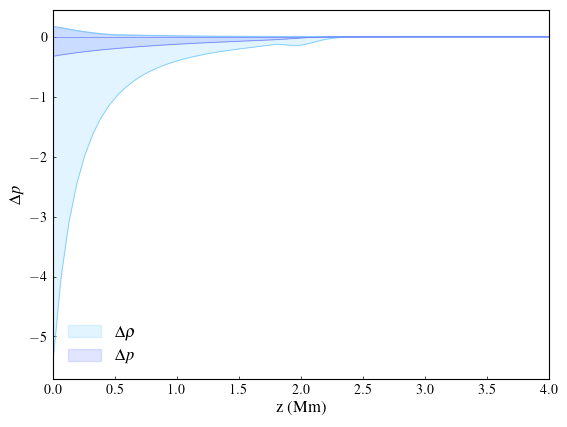

In [77]:
fig, ax1 = plt.subplots()

ax1.plot(
    data2d.z,
    ddmhs_max,
    linewidth=0.5,
    color=c1,
    # label=r"B-den, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    ddmhs_min,
    linewidth=0.5,
    color=c1,
    # label=r"B-den, $p_0$ prescribed, linear",
)

ax1.plot(
    data2d.z,
    dpmhs_max,
    linewidth=0.5,
    color=c2,
    # label=r"B-den, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    dpmhs_min,
    linewidth=0.5,
    color=c2,
    # label=r"B-den, $p_0$ prescribed, linear",
)

# ax1.plot(
#     data3d.z,
#     -BETA0 / (2.0 * H) * T0 / T_PHOTOSPHERE * data3d.bdensity,
#     linewidth=0.8,
#     linestyle="dashed",
#     color=c4,
#     label=r"$\rho_b$",
# )
# ax1.plot(
#     data3d.z,
#     -BETA0 / 2.0 * data3d.bpressure,
#     linewidth=0.8,
#     linestyle="dashed",
#     color=c3,
#     label=r"$p_b$",
# )
ax1.fill_between(data2d.z, ddmhs_min, ddmhs_max, color=c1, alpha=0.2, label=r"$\Delta \rho$")
ax1.fill_between(data2d.z, dpmhs_min, ddmhs_max, color=c2, alpha=0.2, label=r"$\Delta p$")

ax1.set_ylabel(r"$\Delta p$", fontsize=12)
ax1.set_xlabel(r"z (Mm)", fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.tick_params(direction="in", length=2, width=0.5)
ax1.set_xlim(0, 4.0)

plt.show()